In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from setup import setup as s
import seaborn as sns

ModuleNotFoundError: No module named 'setup'

In [2]:
spreads = pd.read_csv('data/spreadspoke_scores.csv')
teams = pd.read_csv('data/nfl_teams.csv')
stadiums = pd.read_csv('data/nfl_stadiums.csv', header=0,encoding='unicode_escape')

FileNotFoundError: [Errno 2] No such file or directory: 'data/spreadspoke_scores.csv'

In [747]:
def merge(dataframe1, dataframe2, column_1, column_2, type):
    '''
        Merge two dataframes
        column_1: column in dataframe1
        column_2: column in dataframe2
        type: which type of join i.e type in 'left', 'right', 'inner', 'outer'
    '''
    merged_df = pd.merge(dataframe1, dataframe2, left_on=column_1, right_on=column_2, how=type)
    return merged_df

In [748]:
data = merge(spreads, stadiums, 'stadium', 'stadium_name', 'left')

In [749]:
data['team_home'] = data.team_home.map(teams.set_index('team_name')['team_id'].to_dict())
data['team_away'] = data.team_away.map(teams.set_index('team_name')['team_id'].to_dict())

In [750]:
data = s.filter_df(data,'schedule_playoff', False, 'eq')
data = s.filter_df(data, 'stadium_neutral', False, 'eq')
data = s.filter_df(data, 'schedule_season', 2008, 'greq')
data = s.filter_df(data, 'schedule_season', 2018, 'leq')

data['spread_favorite'] = np.where(data['team_favorite_id'] == data['team_away'],
                                       np.abs(data['spread_favorite']),
                                       data['spread_favorite'])
data['home_away'] = data['spread_favorite'].apply(lambda x: 1 if x < 0 else 0)

In [751]:
def replace_values_in_columns(dataframe, columns, old_value, new_value):
    '''
    Replace values in specified columns of a DataFrame
    dataframe: the DataFrame to modify
    columns: a list of column names where replacement should occur
    old_value: the value(s) to be replaced
    new_value: the value(s) to replace with
    '''
    dataframe[columns] = dataframe[columns].replace(old_value, new_value)
    return dataframe

In [752]:
data = replace_values_in_columns(data, ['team_home', 'team_away'], 'St. Louis Rams', 'Los Angeles Rams')
data = replace_values_in_columns(data, ['team_home', 'team_away'], 'San Diego Chargers', 'Los Angeles Chargers')

In [753]:
##Check there are 32 home and away teams in our dataset
data['team_home'].nunique() , data['team_away'].nunique()

(32, 32)

In [754]:
###Home and Away Data
home_away = data.iloc[:,:10]

In [755]:
def calculate_stats(dataframe, groupby_cols, agg_col):
    '''
    Calculate statistics for a column(s) grouped by specified column(s)
    dataframe: DataFrame to perform aggregation on
    groupby_cols: list of columns to group by
    agg_col: column to perform aggregation on
    '''
    stats = dataframe.groupby(groupby_cols)[agg_col].agg(['mean', 'median', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
    stats.rename(columns={
        '<lambda_0>': '25th Percentile',
        '<lambda_1>': '75th Percentile'
    }, inplace=True)
    return stats


In [756]:
##General Home Team Spread Stats per Season

home_stats = calculate_stats(data, ['schedule_season'], 'spread_favorite')

In [757]:
home_stats

,mean,median,min,max,25th Percentile,75th Percentile
schedule_season,,,,,,
2008,-2.716535,-3.0,-17.0,11.0,-6.875,3.0
2009,-2.608268,-3.0,-17.0,14.5,-8.000,3.0
2010,-2.393281,-3.0,-14.5,13.5,-6.500,3.0
2011,-2.421260,-3.0,-20.5,14.0,-7.000,3.0
2012,-2.251969,-3.0,-17.0,14.5,-6.500,3.0
2013,-2.450593,-3.0,-26.5,13.0,-6.500,2.5
2014,-2.413043,-3.0,-16.5,13.0,-6.500,2.5
2015,-2.171937,-3.0,-16.5,13.0,-6.000,2.5
2016,-2.103175,-3.0,-17.0,11.5,-6.000,2.5


In [758]:
##General Home Team Spread Stats per Week in each Season
home_stats_week = calculate_stats(data, ['schedule_season', 'schedule_week'], 'spread_favorite')


In [759]:
##Each home team's spread stats per season 
individ_home_stats = calculate_stats(data, ['team_home', 'schedule_season'], 'spread_favorite')

<Figure size 1000x600 with 0 Axes>

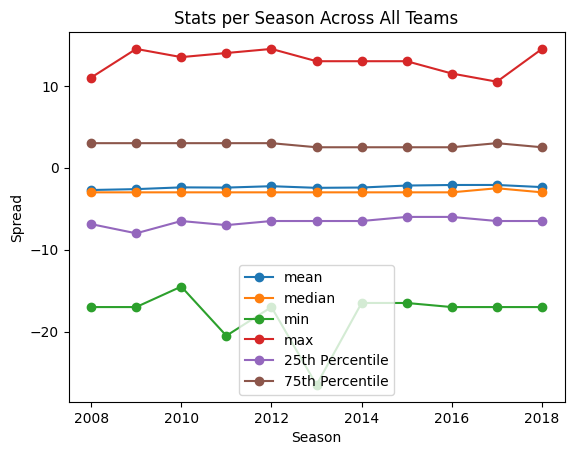

In [760]:
plt.figure(figsize=(10, 6))
home_stats.plot(marker='o')
plt.title('Stats per Season Across All Teams')
plt.xlabel('Season')
plt.ylabel('Spread')
plt.show()

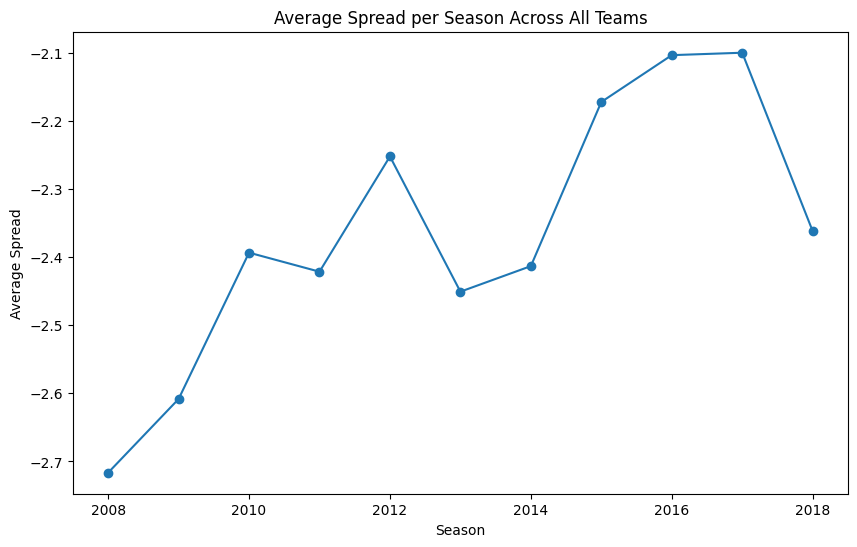

In [761]:
plt.figure(figsize=(10, 6))
home_stats['mean'].plot(marker='o')
plt.title('Average Spread per Season Across All Teams')
plt.xlabel('Season')
plt.ylabel('Average Spread')
plt.show()

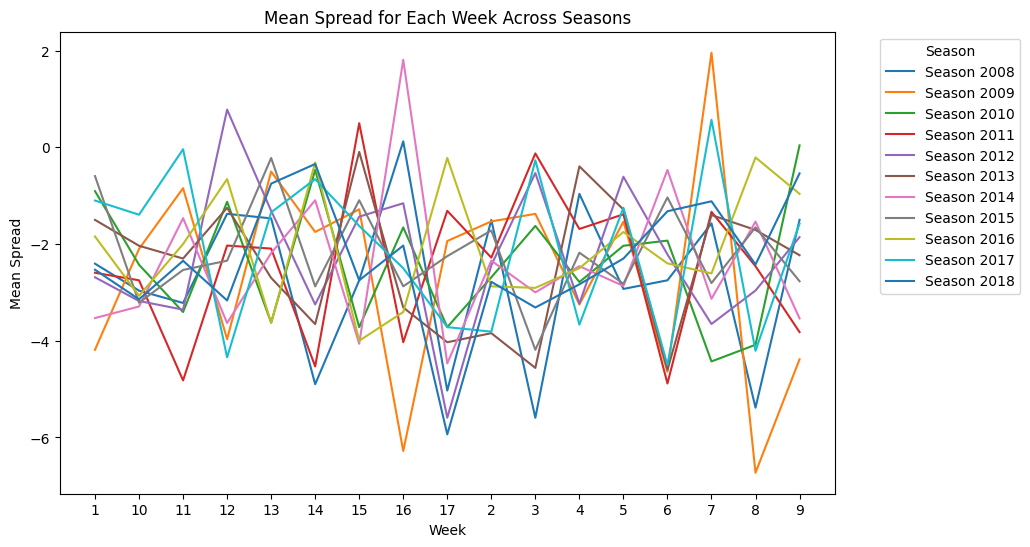

In [762]:
home_stats_week.reset_index(inplace=True)

plt.figure(figsize=(10, 6))

seasons = home_stats_week['schedule_season'].unique()

for season in seasons:
    season_data = home_stats_week[home_stats_week['schedule_season'] == season]
    plt.plot(season_data['schedule_week'], season_data['mean'], label=f'Season {season}')

plt.title('Mean Spread for Each Week Across Seasons')
plt.xlabel('Week')
plt.ylabel('Mean Spread')
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

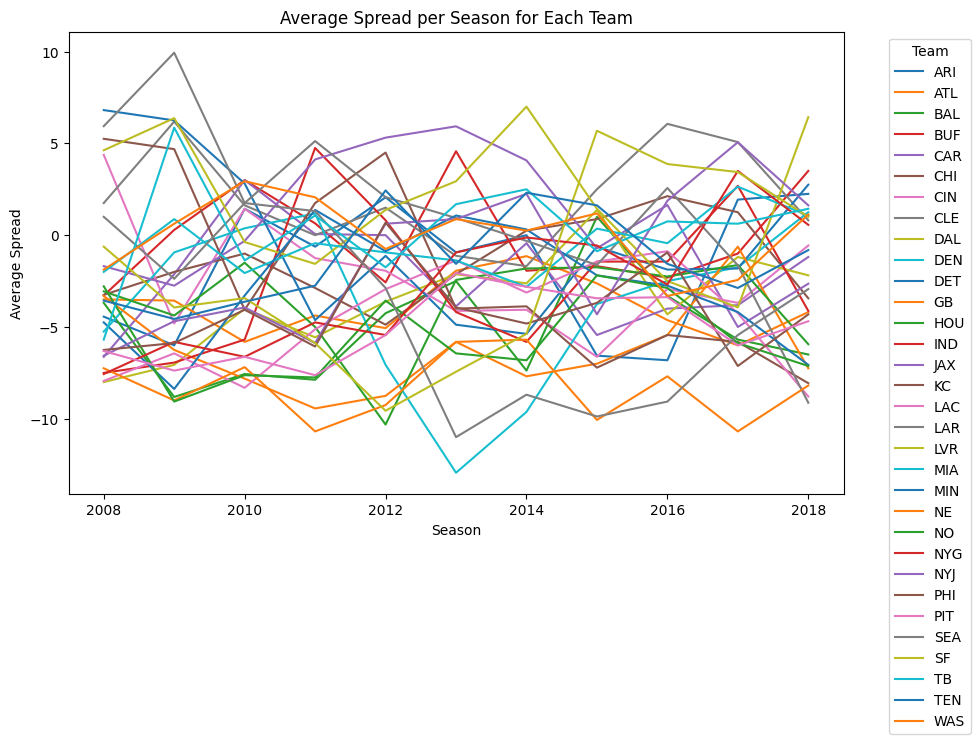

In [763]:
individ_home_stats.reset_index(inplace=True)

plt.figure(figsize=(10, 6))

teams = individ_home_stats['team_home'].unique() 

for team in teams:
    team_data = individ_home_stats[individ_home_stats['team_home'] == team]
    plt.plot(team_data['schedule_season'], team_data['mean'], label=team)

plt.title('Average Spread per Season for Each Team')
plt.xlabel('Season')
plt.ylabel('Average Spread')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [764]:
###Stadiums (Outdoor Indoor or Retractable)

In [765]:
data['stadium_type'].isnull().sum()

0

In [766]:
data = replace_values_in_columns(data, ['stadium_type'], 'retractable', 'indoor')

In [767]:
stadiums = data[['stadium', 'stadium_type']].drop_duplicates()

/Users/rhonishnair/Time-Series-Project---Forecasting-spreads-in-sports-betting/setup.py:70: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


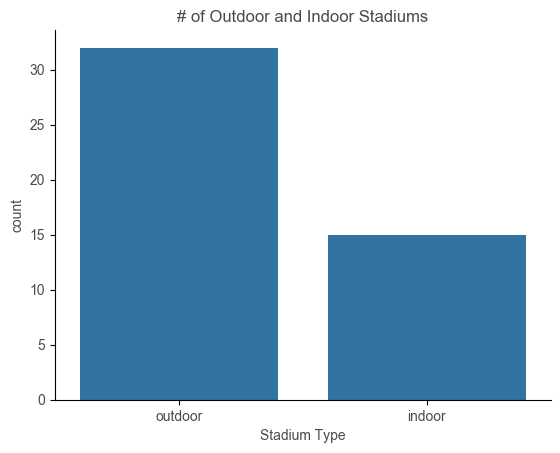

In [768]:
counts = stadiums['stadium_type'].value_counts().reset_index()
counts.columns = ['stadium_type', 'count']
s.custom_plot(x ='stadium_type', y ='count', data = counts, type = 'bar', title='# of Outdoor and Indoor Stadiums', x_label= 'Stadium Type', y_label = 'count')

In [769]:
##Basic Stats for each stadium type in the 10 years
stadium_type_stats = calculate_stats(data, ['stadium_type'], 'spread_favorite')

In [770]:
###Basic Stats for each stadium over each season
stadium_type_season_stats = calculate_stats(data, ['schedule_season', 'stadium_type'], 'spread_favorite')

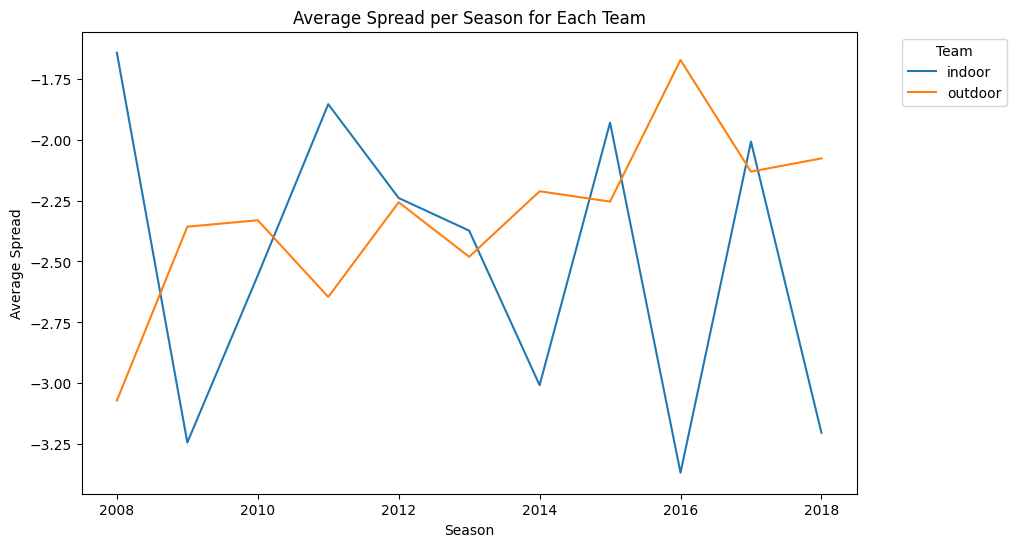

In [771]:
stadium_type_season_stats.reset_index(inplace=True)

plt.figure(figsize=(10, 6))

stadium_type = stadium_type_season_stats['stadium_type'].unique() 

for stadium in stadium_type:
    team_data = stadium_type_season_stats[stadium_type_season_stats['stadium_type'] == stadium]
    plt.plot(team_data['schedule_season'], team_data['mean'], label=stadium)

plt.title('Average Spread per Season for Each Team')
plt.xlabel('Season')
plt.ylabel('Average Spread')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [772]:
###Stadium Capacity
data[data['stadium_capacity'].isnull()].iloc[:,10:25]

,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type
9474,41.5,Giants Stadium,False,79.0,10.0,61.0,NaN,Giants Stadium,"East Rutherford, NJ",1976.0,2009.0,outdoor,"1 MetLife Stadium Dr, East Rutherford, NJ 07073",7073,cold
9480,36,Sun Life Stadium,False,84.0,9.0,70.0,NaN,Sun Life Stadium,"Miami Gardens, FL",1987.0,NaN,outdoor,"347 Don Shula Dr, Miami Gardens, FL 33056",33056,warm
9486,42,Candlestick Park,False,66.0,16.0,67.0,NaN,Candlestick Park,"San Francisco, CA",1960.0,2013.0,outdoor,"490 Jamestown Ave, San Francisco, CA 94124",94124,moderate
9498,43.5,Hubert H. Humphrey Metrodome,False,72.0,0.0,NaN,indoor,Hubert H. Humphrey Metrodome,"Minneapolis, MN",1982.0,2009.0,indoor,"900 S 5th St, Minneapolis, MN 55415",55415,dome
9499,37,Giants Stadium,False,77.0,11.0,75.0,NaN,Giants Stadium,"East Rutherford, NJ",1976.0,2009.0,outdoor,"1 MetLife Stadium Dr, East Rutherford, NJ 07073",7073,cold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11710,46,Sun Life Stadium,False,80.0,10.0,NaN,NaN,Sun Life Stadium,"Miami Gardens, FL",1987.0,NaN,outdoor,"347 Don Shula Dr, Miami Gardens, FL 33056",33056,warm
11736,45,Sun Life Stadium,False,79.0,11.0,NaN,NaN,Sun Life Stadium,"Miami Gardens, FL",1987.0,NaN,outdoor,"347 Don Shula Dr, Miami Gardens, FL 33056",33056,warm
11781,45,Sun Life Stadium,False,79.0,10.0,NaN,NaN,Sun Life Stadium,"Miami Gardens, FL",1987.0,NaN,outdoor,"347 Don Shula Dr, Miami Gardens, FL 33056",33056,warm
11811,44,Sun Life Stadium,False,75.0,15.0,NaN,NaN,Sun Life Stadium,"Miami Gardens, FL",1987.0,NaN,outdoor,"347 Don Shula Dr, Miami Gardens, FL 33056",33056,warm


In [773]:
data[['stadium_name']].value_counts()

stadium_name                       
MetLife Stadium                        144
Ford Field                              89
Lucas Oil Stadium                       88
Sports Authority Field at Mile High     88
Soldier Field                           88
M&T Bank Stadium                        88
Lincoln Financial Field                 88
Lambeau Field                           88
Heinz Field                             88
Gillette Stadium                        88
University of Phoenix Stadium           88
FedEx Field                             88
CenturyLink Field                       88
Bank of America Stadium                 88
Arrowhead Stadium                       87
FirstEnergy Stadium                     87
Paul Brown Stadium                      87
Raymond James Stadium                   86
Oakland Coliseum                        84
Nissan Stadium                          80
Georgia Dome                            79
EverBank Field                          76
Reliant Stadium   

In [774]:
subset_null_capacity = data[data['stadium_capacity'].isnull()]

# Filter based on null stadium capacity and home team
subset_with_null_capacity = subset_null_capacity[['team_home', 'stadium', 'stadium_capacity']]


In [775]:
subset_with_null_capacity.groupby(['team_home', 'stadium'])['stadium_capacity'].count()

team_home  stadium                     
DAL        Texas Stadium                   0
LAR        Edward Jones Dome               0
MIA        Sun Life Stadium                0
MIN        Hubert H. Humphrey Metrodome    0
           Mall of America Field           0
           TCF Bank Stadium                0
NYG        Giants Stadium                  0
NYJ        Giants Stadium                  0
SF         Candlestick Park                0
Name: stadium_capacity, dtype: int64

In [776]:
stadium_capacity_mapping = {
    'Texas Stadium': '66,000',
    'Edward Jones Dome': '67,000',
    'Sun Life Stadium': '65,000',
    'Hubert H. Humphrey Metrodome': '64,000',
    'Mall of America Field': '64,000',
    'TCF Bank Stadium': '50,000',
    'Giants Stadium': '82,500',
    'Candlestick Park': '70,000'
}
data['stadium_capacity'] = data.apply(
    lambda row: stadium_capacity_mapping.get(row['stadium'], row['stadium_capacity']), axis=1
)


In [777]:
###Stadium Surface (turf or grass)

subset_null_capacity = data[data['stadium_surface'].isnull()]

# Filter based on null stadium capacity and home team
subset_with_null_capacity = subset_null_capacity[['team_home', 'stadium', 'stadium_surface']]

In [778]:
stadium_surface = {
    'Texas Stadium': 'FieldTurf',
    'Edward Jones Dome': 'FieldTurf',
    'Sun Life Stadium': 'Grass',
    'Hubert H. Humphrey Metrodome': 'FieldTurf',
    'Mall of America Field': 'FieldTurf',
    'TCF Bank Stadium': 'FieldTurf',
    'Giants Stadium': 'Grass',
    'Candlestick Park': 'Grass'
}
data['stadium_surface'] = data.apply(
    lambda row: stadium_surface.get(row['stadium'], row['stadium_surface']), axis=1
)


In [779]:
new_data = data[['schedule_date', 'schedule_season', 'schedule_week', 'home_away', 'stadium_surface', 'stadium_type', 'stadium_capacity', 'spread_favorite']]

In [780]:
new_data['schedule_date'] = pd.to_datetime(new_data['schedule_date'])

/var/folders/78/_y3n_8013ls3d51pyk45clh80000gn/T/ipykernel_49482/2400606313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['schedule_date'] = pd.to_datetime(new_data['schedule_date'])


In [781]:
new_data.index = new_data['schedule_date']

In [783]:
new_data.replace([np.inf, -np.inf], 0, inplace=True)

/var/folders/78/_y3n_8013ls3d51pyk45clh80000gn/T/ipykernel_49482/1966273542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.replace([np.inf, -np.inf], 0, inplace=True)


In [784]:
train_start, train_end = s.filter_df(new_data, 'schedule_season', 2008, 'greq'), s.filter_df(new_data, 'schedule_season', 2016, 'leq')
test_start, test_end = s.filter_df(new_data, 'schedule_season', 2017, 'greq'), s.filter_df(new_data, 'schedule_season', 2018, 'leq')

In [785]:
train = s.filter_df(new_data, 'schedule_season', 2016, 'leq')
test = s.filter_df(new_data, 'schedule_season', 2017, 'greq')

In [794]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Assuming 'train_data' and 'test_data' are your train and test datasets
# Sort both train and test data by date or week


# Create dummy variables for home and away teams in both train and test data
train_exog_surface = pd.get_dummies(train['stadium_surface'], drop_first=True)
train_exog_type = pd.get_dummies(train['stadium_type'], drop_first=True)



test_exog_surface = pd.get_dummies(test['stadium_surface'], drop_first=True)
test_exog_type = pd.get_dummies(test['stadium_type'], drop_first=True)

# Concatenate the exogenous variables for train and test datasets
train_exog = pd.concat([train[['home_away', 'stadium_capacity']],train_exog_surface, train_exog_type], axis=1)
test_exog = pd.concat([test[['home_away', 'stadium_capacity']],test_exog_surface, test_exog_type], axis=1)

# Set the index to date for train and test data
train_exog.index = train['schedule_date']
test_exog.index = test['schedule_date']
train_exog['Grass'] = train_exog['Grass'].astype('int64')
train_exog['outdoor'] = train_exog['outdoor'].astype('int64')

test_exog['Grass'] = test_exog['Grass'].astype('int64')
test_exog['outdoor'] = test_exog['outdoor'].astype('int64')
train_exog['stadium_capacity'] = train_exog['stadium_capacity'].str.replace(',', '').astype(float)
test_exog['stadium_capacity'] = test_exog['stadium_capacity'].str.replace(',', '').astype(float)

# Define the endogenous variable (spread) for train and test datasets
train_endog = train['spread_favorite']
test_endog = test['spread_favorite']




In [864]:
import itertools

# Define the range of p, d, q values to test
p_values = range(0, 4)  # Change these ranges as needed
q_values = range(0, 4)  # Change these ranges as needed

best_aic = float('inf')
best_order = None

# Iterate over all combinations of p, d, q values
for p in p_values:
   for q in q_values:
        order = (p, 0, q)
        try:
            # Fit the ARIMA model
            model = sm.tsa.ARIMA(train_endog, order=order, exog=train_exog, enforce_stationarity= True)
            results = model.fit()

            # Check AIC for model goodness of fit
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order

        except:
            continue

print(f"Best AIC: {best_aic} for order: {best_order}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarnin

Best AIC: 11984.656390349588 for order: (2, 0, 2)


In [865]:
forecast = results.predict(start=len(train_endog), end=len(train_endog) + len(test) - 1, exog=test_exog)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [855]:
forecast_df = forecast.reset_index()
forecast_df.columns = ['schedule_date', 'Forecast_ARIMAX']
forecast_df.set_index(test.index, inplace=True)
forecast_df = forecast_df.drop(columns = 'schedule_date')
forecast_df['actual_spread'] = test['spread_favorite']
forecast_df['Percent_Error'] = (abs(forecast_df['actual_spread'] - forecast_df['Forecast_ARIMAX']) / forecast_df['actual_spread']) * 100


In [860]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(forecast_df['actual_spread'], forecast_df['Forecast_ARIMAX'])
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 11.987665821391863


In [861]:
forecast_df

,Forecast_ARIMAX,actual_spread,Percent_Error
schedule_date,,,
2017-09-07,-5.881720,-9.0,-34.647551
2017-09-10,-6.067224,-9.5,-36.134484
2017-09-10,4.649992,7.0,33.571542
2017-09-10,-5.936720,-3.0,-97.890680
2017-09-10,4.581673,9.0,49.092517
...,...,...,...
2018-12-30,-5.690101,-14.0,-59.356422
2018-12-30,-5.926313,-14.0,-57.669191
2018-12-30,4.580506,2.5,83.220247
